# Bibliotecas:

In [608]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit



# Analise de dados:

In [609]:
df_ibovespa = pd.read_csv('/content/Dados Históricos - Ibovespa.csv', sep = ',')

In [610]:
df_ibovespa.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,22.08.2025,137.968,134.511,138.072,134.511,"9,32B","2,57%"
1,21.08.2025,134.511,134.664,134.837,133.874,"6,52B","-0,12%"
2,20.08.2025,134.666,134.430,134.964,134.122,"6,85B","0,17%"
3,19.08.2025,134.432,137.321,137.321,133.997,"8,68B","-2,10%"
4,18.08.2025,137.322,136.341,137.902,136.341,"8,09B","0,72%"


In [611]:
df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3741 entries, 0 to 3740
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      3741 non-null   object 
 1   Último    3741 non-null   float64
 2   Abertura  3741 non-null   float64
 3   Máxima    3741 non-null   float64
 4   Mínima    3741 non-null   float64
 5   Vol.      3740 non-null   object 
 6   Var%      3741 non-null   object 
dtypes: float64(4), object(3)
memory usage: 204.7+ KB


In [612]:
# Transformando a coluna Data em indice e ordenando cronologicamente
df_ibovespa['Data'] = pd.to_datetime(df_ibovespa['Data'], dayfirst=True)
df_ibovespa.set_index('Data', inplace=True)
df_ibovespa.sort_index(inplace=True)


In [613]:
df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3741 entries, 2010-07-23 to 2025-08-22
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    3741 non-null   float64
 1   Abertura  3741 non-null   float64
 2   Máxima    3741 non-null   float64
 3   Mínima    3741 non-null   float64
 4   Vol.      3740 non-null   object 
 5   Var%      3741 non-null   object 
dtypes: float64(4), object(2)
memory usage: 204.6+ KB


In [614]:
df_ibovespa.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2010-07-23,66.323,65.748,66.323,65.427,"1,54M","0,87%"
2010-07-26,66.443,66.322,66.619,66.151,"1,23M","0,18%"
2010-07-27,66.674,66.449,67.102,66.293,"1,60M","0,35%"
2010-07-28,66.808,66.670,67.051,66.427,"1,94M","0,20%"
2010-07-29,66.954,66.796,67.428,66.596,"2,16M","0,22%"


In [615]:
# Limpando as colunas:
def limpar_valor(valor):
    if pd.isna(valor):
        return None
    valor = str(valor).replace('%', '').replace('.', '').replace(',', '.').strip()
    try:
        if 'K' in valor:
            return float(valor.replace('K', '')) * 1_000
        elif 'M' in valor:
            return float(valor.replace('M', '')) * 1_000_000
        elif 'B' in valor:
            return float(valor.replace('B', '')) * 1_000_000_000
        else:
            return float(valor)
    except ValueError:
        return None

for coluna in df_ibovespa.select_dtypes(include='object').columns:
    df_ibovespa[coluna] = df_ibovespa[coluna].apply(limpar_valor)



In [616]:
df_ibovespa.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2010-07-23,66.323,65.748,66.323,65.427,1540000.0,0.87
2010-07-26,66.443,66.322,66.619,66.151,1230000.0,0.18
2010-07-27,66.674,66.449,67.102,66.293,1600000.0,0.35
2010-07-28,66.808,66.670,67.051,66.427,1940000.0,0.20
2010-07-29,66.954,66.796,67.428,66.596,2160000.0,0.22


In [617]:
# Normalizando os dados
colunas_numericas = df_ibovespa.select_dtypes(include='float64').columns
scaler = StandardScaler()
df_ibovespa[colunas_numericas] = scaler.fit_transform(df_ibovespa[colunas_numericas])



In [618]:
df_ibovespa.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2010-07-23,-0.603782,-0.623244,-0.625828,-0.612149,-0.204741,0.572195
2010-07-26,-0.599642,-0.603435,-0.615667,-0.587039,-0.204893,0.101825
2010-07-27,-0.591674,-0.599053,-0.599086,-0.582114,-0.204711,0.217713
2010-07-28,-0.587051,-0.591426,-0.600837,-0.577466,-0.204545,0.115458
2010-07-29,-0.582015,-0.587078,-0.587895,-0.571605,-0.204437,0.129092


In [619]:
# Verificando se a série é estacionária:
resultado_adf = adfuller(df_ibovespa['Último'])
estatistica = resultado_adf[0]
p_valor = resultado_adf[1]
valores_criticos = resultado_adf[4]

print(f'Estatística ADF: {estatistica:.4f}')
print(f'Valor-p: {p_valor:.4f}')

for chave, valor in valores_criticos.items():
    print(f'Valor crítico ({chave}): {valor:.4f}')
if p_valor < 0.05:
    print("\n Conclusão: A série é estacionária (rejeitamos a hipótese nula).")
else:
    print("\n Conclusão: A série NÃO é estacionária (não rejeitamos a hipótese nula).")


Estatística ADF: -0.6261
Valor-p: 0.8650
Valor crítico (1%): -3.4321
Valor crítico (5%): -2.8623
Valor crítico (10%): -2.5672

 Conclusão: A série NÃO é estacionária (não rejeitamos a hipótese nula).


In [620]:
# Usando o modelo aditivo
decomposicao = seasonal_decompose(df_ibovespa['Último'], model='additive', period=30)

# Extraindo o componente residual
df_ibovespa['residuo'] = decomposicao.resid.dropna()



In [621]:
resultado = adfuller(df_ibovespa['residuo'].dropna())

print(f'Estatística ADF: {resultado[0]:.4f}')
print(f'Valor-p: {resultado[1]:.4f}')
for chave, valor in resultado[4].items():
    print(f'Valor crítico ({chave}): {valor:.4f}')

if resultado[1] < 0.05:
    print("\n Conclusão: O componente residual é estacionário.")
else:
    print("\n Conclusão: O componente residual ainda NÃO é estacionário.")


Estatística ADF: -15.2858
Valor-p: 0.0000
Valor crítico (1%): -3.4321
Valor crítico (5%): -2.8623
Valor crítico (10%): -2.5672

 Conclusão: O componente residual é estacionário.


Após tentar tornar a série estacionária com diferença de primeira ordem, log-transformação + diferença e diferença de segunda ordem sem êxito, foi feita a decomposição dos dados para verificar a estacionaridade do resíduo.

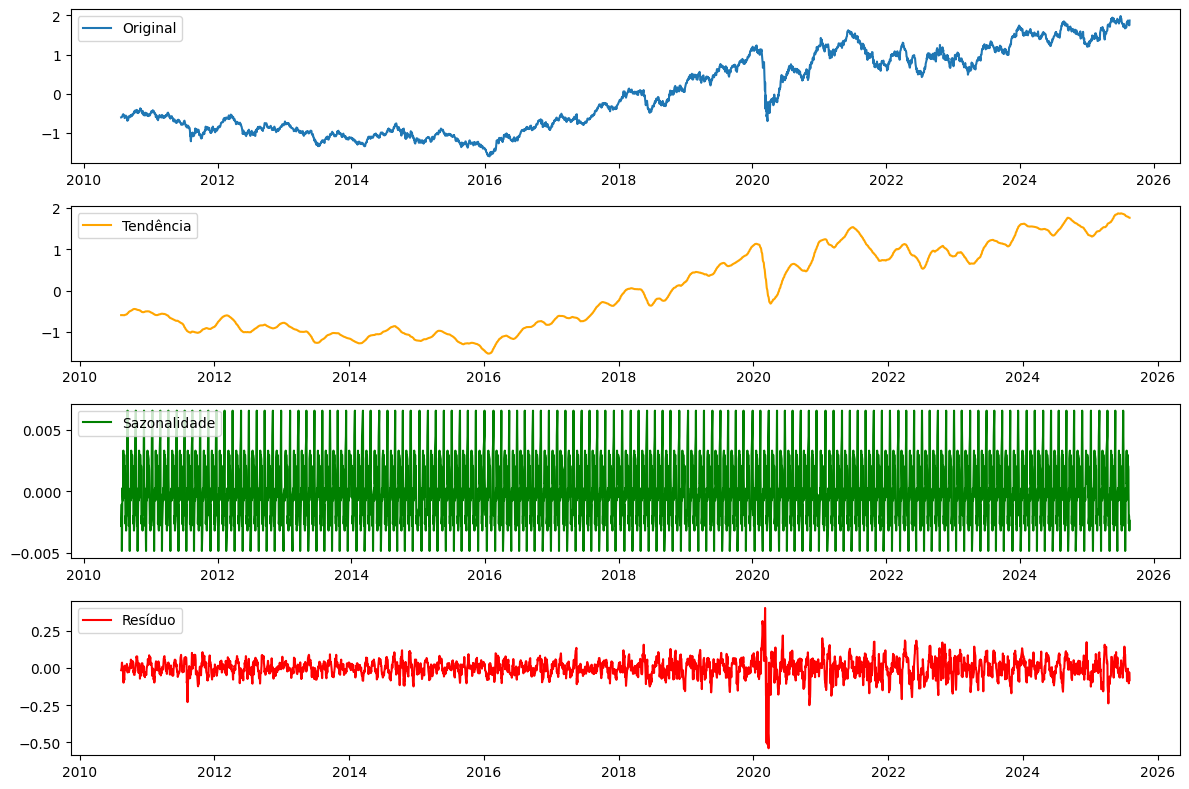

In [622]:
# Decomposição aditiva (já que a série tem valores negativos)
decomposicao = seasonal_decompose(df_ibovespa['Último'], model='additive', period=30)

# Plotando os componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposicao.observed, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposicao.trend, label='Tendência', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposicao.seasonal, label='Sazonalidade', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposicao.resid, label='Resíduo', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


Podemos ver claramente no rúido o impacto da pândemia no período próximo há 2020.

FEATURES:

In [623]:
#Retorno diário e semanal:
df_ibovespa['Retorno_Diario'] = df_ibovespa['Último'].pct_change()
df_ibovespa['Retorno_Semanal'] = df_ibovespa['Último'].pct_change(periods=5)

#Volatilidade (desvio padrão móvel):
df_ibovespa['Volatilidade_5d'] = df_ibovespa['Último'].rolling(window=5).std()
df_ibovespa['Volatilidade_10d'] = df_ibovespa['Último'].rolling(window=10).std()

#Médias móveis - captura tendências ao longo do tempo:
df_ibovespa['MM_5d'] = df_ibovespa['Último'].rolling(window=5).mean()
df_ibovespa['MM_20d'] = df_ibovespa['Último'].rolling(window=20).mean()
df_ibovespa['MM_60d'] = df_ibovespa['Último'].rolling(window=60).mean()
df_ibovespa['MM_200d'] = df_ibovespa['Último'].rolling(window=200).mean()

#Variação percentual:
df_ibovespa['Var%'] = df_ibovespa['Var%']

#Volume negociado:
df_ibovespa['Vol.'] = df_ibovespa['Vol.']

#Alvo: Alta ou baixa no dia seguinte:
df_ibovespa['Target'] = (df_ibovespa['Último'].shift(-1) > df_ibovespa['Último']).astype(int)

#Limpeza final para modelagem:
df_modelo = df_ibovespa.dropna(subset=[
    'residuo', 'Retorno_Diario', 'Retorno_Semanal',
    'Volatilidade_5d', 'Volatilidade_10d',
    'MM_5d', 'MM_20d', 'MM_60d', 'MM_200d', 'Var%', 'Vol.', 'Target'
])

#Separando features e alvo:
X = df_modelo[['residuo', 'Retorno_Diario', 'Retorno_Semanal',
               'Volatilidade_5d', 'Volatilidade_10d',
               'MM_5d', 'MM_20d', 'MM_60d', 'MM_200d', 'Var%', 'Vol.']]

y = df_modelo['Target']



In [624]:
df_ibovespa.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,residuo,Retorno_Diario,Retorno_Semanal,Volatilidade_5d,Volatilidade_10d,MM_5d,MM_20d,MM_60d,MM_200d,Target
Data,,,,,,,,,,,,,,,,
2010-07-23,-0.603782,-0.623244,-0.625828,-0.612149,-0.204741,0.572195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2010-07-26,-0.599642,-0.603435,-0.615667,-0.587039,-0.204893,0.101825,NaN,-0.006856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2010-07-27,-0.591674,-0.599053,-0.599086,-0.582114,-0.204711,0.217713,NaN,-0.013289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2010-07-28,-0.587051,-0.591426,-0.600837,-0.577466,-0.204545,0.115458,NaN,-0.007812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2010-07-29,-0.582015,-0.587078,-0.587895,-0.571605,-0.204437,0.129092,NaN,-0.008579,NaN,0.008917,NaN,-0.592833,NaN,NaN,NaN,1


# Modelagem: Regressão logística

In [625]:
delta = df_ibovespa['Último'].diff()
threshold = 0.005  # 0.5% de variação

df_ibovespa['Target'] = (delta > threshold).astype(int)
df_ibovespa['Delta'] = delta.shift(1)
df_ibovespa['Return'] = df_ibovespa['Último'].pct_change().shift(1)


In [626]:
def make_n_lags(df, n_lags, column):
    for i in range(1, n_lags + 1):
        df[f'{column}_lag{i}'] = df[column].shift(i)
    return df

df_ibovespa = make_n_lags(df_ibovespa, 10, 'Delta')


In [627]:
df_ibovespa['High'] = df_ibovespa['Máxima'].diff().shift(1)
df_ibovespa['Low'] = df_ibovespa['Mínima'].diff().shift(1)
df_ibovespa['Spread'] = df_ibovespa['High'] - df_ibovespa['Low']
df_ibovespa['Volatilidade'] = df_ibovespa['Delta'].rolling(window=5).std()
df_ibovespa['Open'] = df_ibovespa['Abertura'].diff()

# Médias móveis
df_ibovespa['MA5'] = df_ibovespa['Delta'].rolling(window=5).mean()
df_ibovespa['MA22'] = df_ibovespa['Delta'].rolling(window=22).mean()
df_ibovespa['MA66'] = df_ibovespa['Delta'].rolling(window=66).mean()
df_ibovespa['MA132'] = df_ibovespa['Delta'].rolling(window=132).mean()
df_ibovespa['MA252'] = df_ibovespa['Delta'].rolling(window=252).mean()


In [628]:
df_model = df_ibovespa.dropna().copy()
features = [col for col in df_model.columns if col not in ['Último', 'Target']]

X = df_model[features]
y = df_model['Target']


In [629]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [630]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear'))
])

param_grid_lr = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']
}

tscv = TimeSeriesSplit(n_splits=5)
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=tscv)
grid_lr.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10],
                         'clf__penalty': ['l1', 'l2']})

In [631]:

print("Melhores parâmetros:", grid_lr.best_params_)
print("Acurácia:", accuracy_score(y_test, grid_lr.predict(X_test)))
print(classification_report(y_test, grid_lr.predict(X_test)))


Melhores parâmetros: {'clf__C': 0.1, 'clf__penalty': 'l1'}
Acurácia: 0.9899280575539569
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       378
           1       0.98      1.00      0.99       317

    accuracy                           0.99       695
   macro avg       0.99      0.99      0.99       695
weighted avg       0.99      0.99      0.99       695



# Validando o modelo usando o período de pândemia

In [632]:
df_val = df_model.loc['2020-01-01':'2022-12-31'].copy()

X_val = df_val[features]
y_val = df_val['Target']


In [633]:
y_pred_val = grid_lr.predict(X_val)


In [634]:
print(" Acurácia no período 2020–2022:", accuracy_score(y_val, y_pred_val))
print(" Relatório de Classificação:\n", classification_report(y_val, y_pred_val))
print(" Matriz de Confusão:\n", confusion_matrix(y_val, y_pred_val))


 Acurácia no período 2020–2022: 0.9973190348525469
 Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       389
           1       0.99      1.00      1.00       357

    accuracy                           1.00       746
   macro avg       1.00      1.00      1.00       746
weighted avg       1.00      1.00      1.00       746

 Matriz de Confusão:
 [[387   2]
 [  0 357]]


# **Analisando trade-offs entre acurácia e overfitting:**

# Comparação entre treino e teste

In [635]:
acc_treino = accuracy_score(y_train, grid_lr.predict(X_train))
acc_teste = accuracy_score(y_test, grid_lr.predict(X_test))

print(f"Acurácia no treino: {acc_treino:.2%}")
print(f"Acurácia no teste: {acc_teste:.2%}")


Acurácia no treino: 99.57%
Acurácia no teste: 98.99%


# Curva de aprendizado

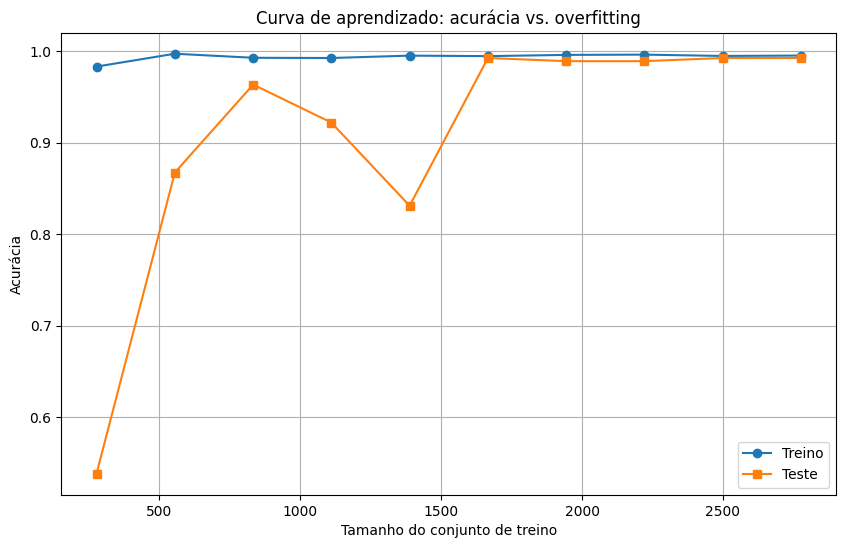

In [636]:
train_sizes, train_scores, test_scores = learning_curve(
    grid_lr.best_estimator_, X, y, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Treino', marker='o')
plt.plot(train_sizes, test_mean, label='Teste', marker='s')
plt.xlabel('Tamanho do conjunto de treino')
plt.ylabel('Acurácia')
plt.title('Curva de aprendizado: acurácia vs. overfitting')
plt.legend()
plt.grid(True)
plt.show()


# Curva ROC e AUC

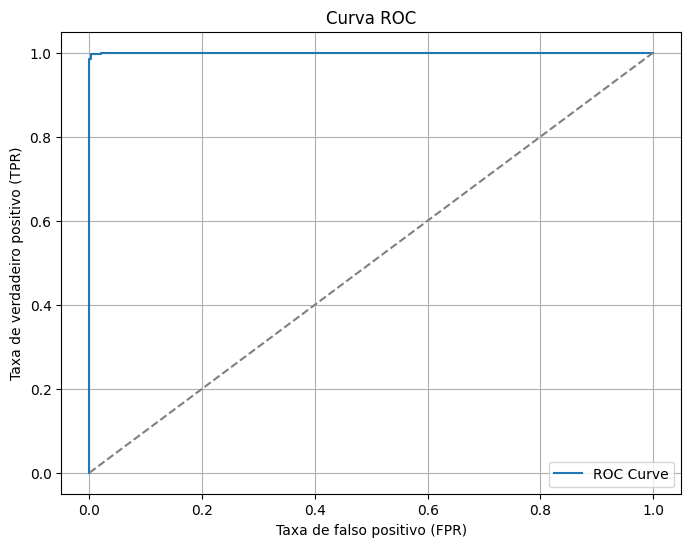

AUC: 0.9999


In [637]:
y_proba = grid_lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taxa de falso positivo (FPR)')
plt.ylabel('Taxa de verdadeiro positivo (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")
